<h1>List of attempts</h1>
<ol>
  <li>
    <h3>Adapted laboratory's model to competition</h3>
    <p>Increased input sizes from 256 -> 512, poor validation accuracy: 0.54.
    probably due to overfitting</p>
  </li>
  <li>
    <h3>Data augmentation</h3>
    <p>validation accuracy: 0.58, still too low</p>
  </li>
  <li>
    <h3>Adding dropout layer to conv</h3>
    <p>val acc: 0.54, train acc: 0.78, still poor generalization</p>
  </li>
  <li>
    <h3>Adding dense layer, increasing its size 512->1024 and dropout</h3>
    <p>val acc: 0.35 even worse, slow to converge</p>
  </li>
  <li>
    <h3>Transfer learning attempt</h3>
    <p>Real improvements val acc: 0.82, still have to tune!</p>
  </li>
  <li>
    <h3>VGG19 trial</h3>
    <p>Too slow to learn. Back to vgg16. (Forgot to include vgg19preproc...)</p>
  </li>
  <li>
    <h3>VGG16 hyperparameters tuning</h3>
    <p>Adjusted data augmentation parameters and removed final dense layer, double pass fine tuning and used all training examples for final model</p>
  </li>
</ol>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import tensorflow as tf
import numpy as np

SEED = 1234

# Making results reproducible
tf.random.set_seed(SEED)  
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input 

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(horizontal_flip=True,
                                        rotation_range=20,
                                        width_shift_range=20.0,
                                        height_shift_range=20.0,
                                        zoom_range=0.1,
                                        preprocessing_function=preprocess_input)  # to apply normalization
else:
    train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create validation and test ImageDataGenerator objects
valid_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls

In [ ]:
!unzip '/content/drive/My Drive/Homework1/artificial-neural-networks-and-deep-learning-2020.zip'

In [ ]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import json

# Opening JSON file 
with open('MaskDataset/train_gt.json',) as f:
  # returns JSON object as  
  # a dictionary 
  data = json.load(f)

# Using dataframes for loading the dataset
newDict = {}
newDict["filename"] = data.keys()
newDict["class"] = [str(i) for i in data.values()]

df = pd.DataFrame.from_dict(newDict)

# Train/validation split 90/10
msk = np.random.rand(len(df)) < 0.9
traindf = df[msk]
validdf = df[~msk]


# Loading test set
mypath = 'MaskDataset/test'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
 
newDict = {}
newDict["filename"] = onlyfiles

testdf = pd.DataFrame.from_dict(newDict)


# Getting a summary of the splits
traindf['filename'].count()
print()

validdf['filename'].count()
print()

traindf['class'].value_counts()
print()

validdf['class'].value_counts()
print()

testdf.count()

In [ ]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = os.path.join(cwd, 'MaskDataset')

# Batch size
bs = 16

# img shape
img_h = 224
img_w = 224

num_classes=3

# Training
training_dir = os.path.join(dataset_dir, 'training')
train_gen = train_data_gen.flow_from_dataframe(dataframe=traindf, # used full df for final model
                                               directory=training_dir,
                                               x_col="filename", y_col="class",
                                               class_mode="categorical",
                                               batch_size=bs,
                                               shuffle=True,
                                               target_size=(img_h,img_w),
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
valid_gen = valid_data_gen.flow_from_dataframe(dataframe=validdf,
                                             directory=training_dir,
                                             x_col="filename", y_col="class",
                                             class_mode="categorical",
                                             batch_size=bs,
                                             shuffle=False,
                                             target_size=(img_h,img_w),
                                             seed=SEED)

# Test
test_dir = os.path.join(dataset_dir, 'test')
test_gen = test_data_gen.flow_from_dataframe(dataframe=testdf,
                                             directory=test_dir,
                                             x_col="filename", y_col=None,
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             target_size=(img_h,img_w),
                                             seed=SEED)

In [9]:
# Create Dataset objects
# ----------------------

# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Repeat
# Without calling the repeat function the dataset 
# will be empty after consuming all the images
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Repeat
valid_dataset = valid_dataset.repeat()

# Test
# ----
test_dataset = tf.data.Dataset.from_generator(lambda: test_gen,
                                              output_types=(tf.float32),
                                              output_shapes=([None, img_h, img_w, 3]))

In [ ]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_w, img_h, 3))

#vgg.summary()

In [ ]:
# Create Model
# ------------

finetuning = True

if finetuning:
    freeze_until = 15 # layer from which we want to fine-tune
    for layer in vgg.layers[:freeze_until]:
      layer.trainable = False
else:
    vgg.trainable = False
    
model = tf.keras.Sequential()
model.add(vgg)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# Visualize created model as a table
model.summary()

In [12]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [13]:
import os
from datetime import datetime

# cwd = os.getcwd()

# exps_dir = os.path.join('/content/drive/My Drive/Keras3/', 'classification_experiments')
# if not os.path.exists(exps_dir):
#     os.makedirs(exps_dir)

# now = datetime.now().strftime('%b%d_%H-%M-%S')

# model_name = 'CNN'

# exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
# if not os.path.exists(exp_dir):
#     os.makedirs(exp_dir)
    
callbacks = []

# Model callbacks
# ----------------

# By default shows losses and metrics for both training and validation
# tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
#                                              profile_batch=0,
#                                              histogram_freq=1)  # if 1 shows weights histograms
# callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)

# Learning rate scheduler
# --------------
callbacks.append(tf.keras.callbacks.ReduceLROnPlateau())

In [ ]:
model.fit(x=train_dataset,
          epochs=50,  #### 15 epochs for final evaluation
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen), 
          callbacks=callbacks
          )

In [ ]:
model.evaluate(valid_dataset,steps=len(valid_gen))

In [15]:
# Ultra fine_tuning

for layer in vgg.layers:
  layer.trainable = True

# learning rate
lr = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
model.fit(x=train_dataset,
          epochs=50,  #### 15 epochs for final evaluation
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen), 
          callbacks=callbacks)

In [ ]:
model.evaluate(valid_dataset,steps=len(valid_gen))

In [17]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
test_gen.reset()
pred = model.predict(test_gen,
                    steps=len(test_gen),
                    verbose=1)

In [19]:
predicted_class_indices=np.argmax(pred,axis=1)

filenames = test_gen.filenames

In [ ]:
results = dict(zip(filenames, predicted_class_indices))

create_csv(results, "drive/MyDrive/Homework1")

# Some useful snippets used for visualization

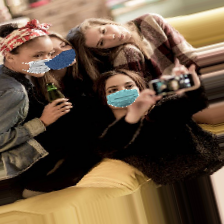

In [ ]:
from PIL import Image

ite = iter(train_dataset)

# Get a test image
img = next(ite)[0]

# Visualize the image
Image.fromarray(np.uint8(np.array(img[0])))

In [ ]:
#Visual proof
from PIL import Image

test_iter = iter(test_dataset)

# Get a test image
test_img = next(test_iter)

result = model(test_img)

print("Predicted class (0=None,1=All,2=Someone): {}".format(np.argmax(result)))

# Visualize the image
Image.fromarray(np.uint8(np.array(test_img[0])*255.))